In [271]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import scipy.stats
from scipy.stats import lognorm, gamma, weibull_min, alpha, invweibull
from scipy.optimize import minimize
from collections import OrderedDict
import math
from itertools import izip

In [272]:
mpl.rcParams['figure.figsize'] = (9.0, 5.0)  # default size of plots
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['legend.fontsize'] = 16

In [3]:
txt_filename = "/Users/robina/Soolin_Users_L1JEC_CMSSW_8_0_0_pre6_Local/L1Trigger/L1JetEnergyCorrections/Stage2_HF_QCDFlatSpring15BX25HCALFix_12Feb_85a0ccf_noJEC_fixedPUS/rsp_clean.txt"

with open(txt_filename) as f:
    rsp = [float(x) for x in f]

In [4]:
rsp = np.array(rsp)
rspInv = 1./rsp

In [181]:
txt_filename = "/Users/robina/Soolin_Users_L1JEC_CMSSW_8_0_0_pre6_Local/L1Trigger/L1JetEnergyCorrections/Stage2_HF_QCDFlatSpring15BX25HCALFix_12Feb_85a0ccf_noJEC_fixedPUS/rsp_ptRef102to106.txt"

with open(txt_filename) as f:
    rspHigh = [float(x) for x in f]

In [182]:
rspHigh = np.array(rspHigh)
rspHighInv = 1./rspHigh

# Scipy fit functions

| Function | Works on response? | Works on 1/response? |
|----------|--------------------|----------------------|
| **Lognormal** | Kinda | Not really |
| Gamma | Kinda | No |
| Alpha | No | Kinda |
| weibull_min | No | No |
| **invweibull** | Kinda | Kinda |

Note that if we find a satisfactory fit function for response, we can easily transform into 1/response space via the Jacobian.

## Lower ptRef bin (10  - 14 Gev) 

##  response

In [256]:

fit_fns = {
        "Normal": dict(fn=scipy.stats.norm),
        "Lognormal":  dict(fn=scipy.stats.lognorm),
        "Gamma":  dict(fn=scipy.stats.gamma),
#         "Alpha": dict(fn=scipy.stats.alpha),
        "Weibull min":  dict(fn=scipy.stats.weibull_min),
        "Inv. weibull":  dict(fn=scipy.stats.invweibull),
        "Inv. gauss":  dict(fn=scipy.stats.invgauss),
        "Fisk":  dict(fn=scipy.stats.fisk),
        "Inv. gamma":  dict(fn=scipy.stats.invgamma),
    }

In [263]:
def plot_multiple_fits(data, fit_fns, x_label, x_range, n_fit_std=10):
    """Plot multiple fits to the data, show all.

    data: numpy.array. Data to fit to. 
    fit_fns: dict[name, function]. Function to fit, and name.
    x_label: str. Label for x axis
    x_range: list[min, max]. Range of x axis
    """
    ncols = 3
    nrows = int(math.ceil(len(fit_fns)/2.))
    fig = plt.gcf()
    fig.set_size_inches(ncols * 6, nrows * 6)
    plt.subplots_adjust(hspace=0.5)

    x_val = np.linspace(x_range[0], x_range[1], 100)

    for i_plt, (fn_name, fit_fn_dict) in enumerate(fit_fns.iteritems(), 1):
        plt.subplot(nrows, ncols, i_plt)
        ax = plt.gca()
        ax.set_title(fn_name + ' fit')
        ax.set_xlabel(x_label)
        mean = data.mean()
        std = data.std()
        mask = (data < mean + (std*n_fit_std)) & (data > mean-(std*n_fit_std))
        data = data[mask]
        n, bins, patches = ax.hist(data, bins=40, range=x_range, normed=True)
        # fit
        fit_results = fit_fn_dict['fn'].fit(data)
        has_shape_param = len(fit_results) == 3
        if has_shape_param:
            shape, loc, scale = fit_results
        else:
            loc, scale = fit_results
            shape = None
        fit_fn_dict['shape'] = shape
        fit_fn_dict['loc'] = loc
        fit_fn_dict['scale'] = scale
            
        if has_shape_param:
            # get mode for fitted fn
            max_result = minimize(lambda x: -1. * fit_fn_dict['fn'].pdf(x, shape, loc=loc, scale=scale), 
                                  x0=0.5*(x_range[0]+x_range[1]))
            mode = max_result.x[0]
            # get mode for proper fnfor (1/x) - include jacobian
            max_result_inv = minimize(lambda x: -1. * np.power(1./x, 2) * fit_fn.pdf(1./x, shape, loc=loc, scale=scale), 
                                     x0=1/(0.5*(x_range[0]+x_range[1])))
            mode_inv = max_result_inv.x[0]
            print fn_name, ':', shape, loc, scale, mode, mode_inv
            y_val = fit_fn_dict['fn'].pdf(x_val, shape, loc=loc, scale=scale)
        else:
            # get mode for fitted fn
            max_result = minimize(lambda x: -1. * fit_fn_dict['fn'].pdf(x, loc=loc, scale=scale), 
                                  x0=0.5*(x_range[0]+x_range[1]))
            mode = max_result.x[0]
            # get mode for proper fnfor (1/x) - include jacobian
            max_result_inv = minimize(lambda x: -1. * np.power(1./x, 2) * fit_fn_dict['fn'].pdf(1./x, loc=loc, scale=scale), 
                                     x0=1/(0.5*(x_range[0]+x_range[1])))
            mode_inv = max_result_inv.x[0]
            print fn_name, ':', loc, scale, mode, mode_inv
            y_val =  fit_fn_dict['fn'].pdf(x_val, loc=loc, scale=scale)

        ax.plot(x_val, y_val, 'r', linewidth=3)  # plot fitted fn

        ax.text(0.5, 0.7, 'mode = %.4f\n1/mode = %.4f\nmode (1/rsp) = %.4f' % (mode, 1./mode, mode_inv), 
                transform=ax.transAxes, fontsize=12)

        # arrow for mode
        ax.vlines(mode, ax.get_ylim()[0], ax.get_ylim()[1], colors=['red'], linestyles='dashed')

Lognormal : 0.424840316369 -0.124175829665 0.53119838748 0.319301307971 0.00788285249256
Weibull min : 1.69736058507 0.0316486029261 0.47814605244 0.314763066488 3.38969073439
Normal : 0.457654752571 0.264282656841 0.457654745345 1.49910247805
Inv. gauss : 0.181202729302 -0.145193346382 3.32692667513 0.315670098707 0.028237681049
Fisk : 3.86248146332 -0.08640309716 0.491336578023 0.341950119231 2.1949087133
Inv. weibull : 13.6079912372 -2.17352035392 2.51034336829 0.323775532561 1.33333333333
Inv. gamma : 9.96488543828 -0.281709348984 6.62579124322 0.32256428535 2.54394906285
Gamma : 3.33196768058 -0.00426583911694 0.138632510752 0.319020836187 1.50027679031


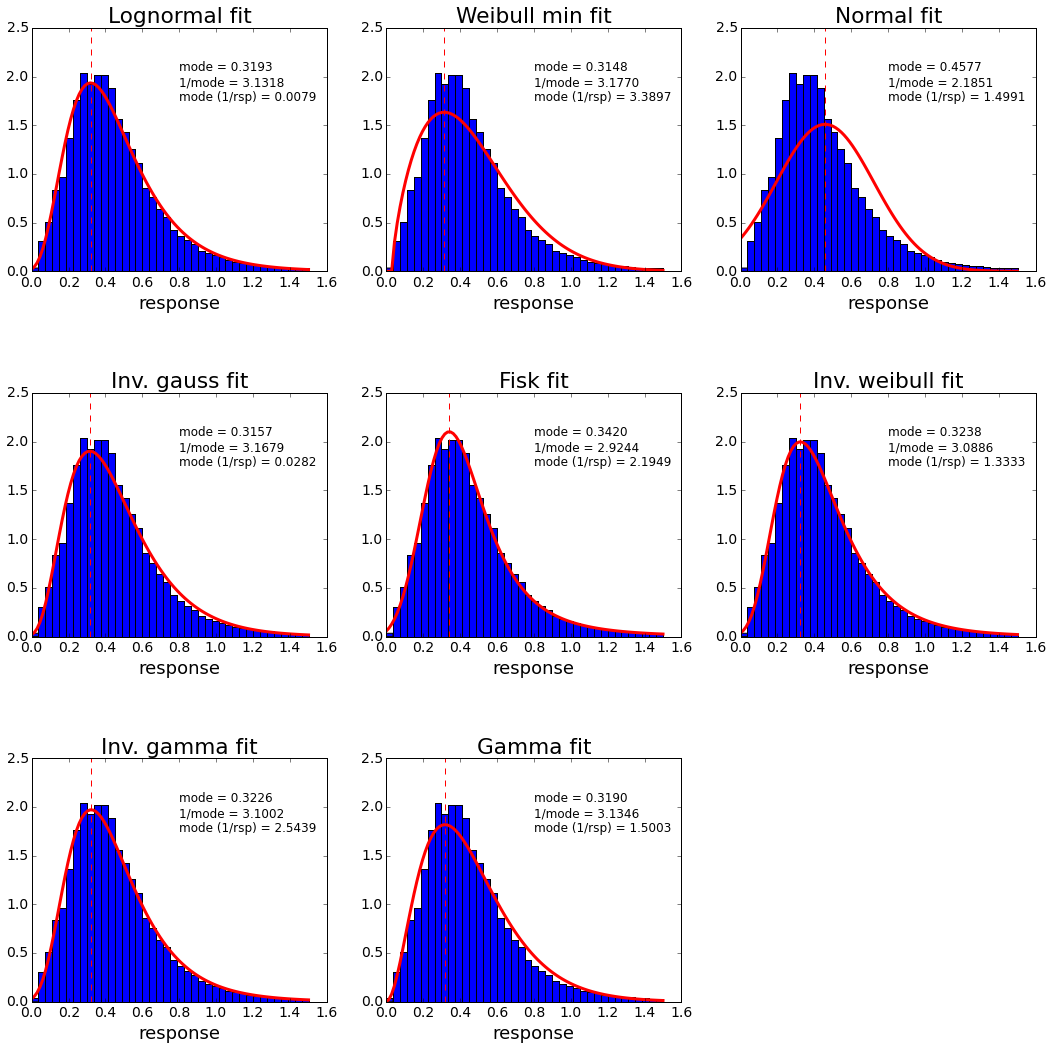

In [264]:
plot_multiple_fits(rsp, fit_fns, 'response', [0, 1.5])

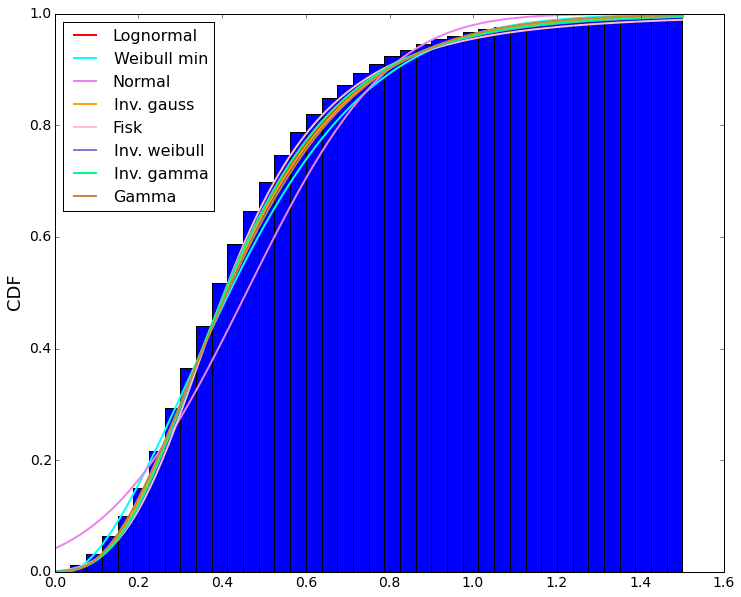

In [279]:
plt.gcf().set_size_inches(12, 10)
plt.hist(rsp, normed=True, cumulative=True, bins=40, range=[0, 1.5])

x = np.linspace(0, 1.5, 100)
colors = ['red', 'cyan', 'violet', 'orange', 'pink', 'mediumpurple', 'springgreen', 'peru']
for color, (fn_name, fit_fn_dict) in izip(colors, fit_fns.iteritems()):
    if fit_fn_dict['shape']:
        y_vals = fit_fn_dict['fn'].cdf(x, fit_fn_dict['shape'], loc=fit_fn_dict['loc'], scale=fit_fn_dict['scale'])
    else:
        y_vals = fit_fn_dict['fn'].cdf(x, loc=fit_fn_dict['loc'], scale=fit_fn_dict['scale'])
    plt.plot(x, y_vals, color=color, linewidth=2, label=fn_name)                                                    
plt.legend(loc=0)
plt.ylabel('CDF')

## 1 / response

Lognormal : 0.695029268708 0.320523883033 2.17901588323 1.66473561428 0.281026040356
Fisk : 2.51110873072 0.405638249412 2.06070707234 1.87864237554 0.330840782523
Weibull min : 1.20560906185 0.500004788932 2.86815171843 1.16137529676 0.205567020181
Normal : 3.16724358273 2.85943277676 3.16724352388 0.168733713969
Inv. gauss : 0.562800246135 0.208316591518 5.25754259679 1.58272233503 0.256857799014
Alpha : 3.0217604561 -1.50484531873 11.9827776326 1.8419749783 0.33063958001
Inv. weibull : 3.22451998942 -1.3771668334 3.42513356024 1.77271011419 0.320648859338
Inv. gamma : 3.77644512263 -0.181201288164 9.13878020838 1.73210088676 0.30786773858
Gamma : 1.70954030857 0.499602186323 1.5604197776 1.60678356314 0.228785565293


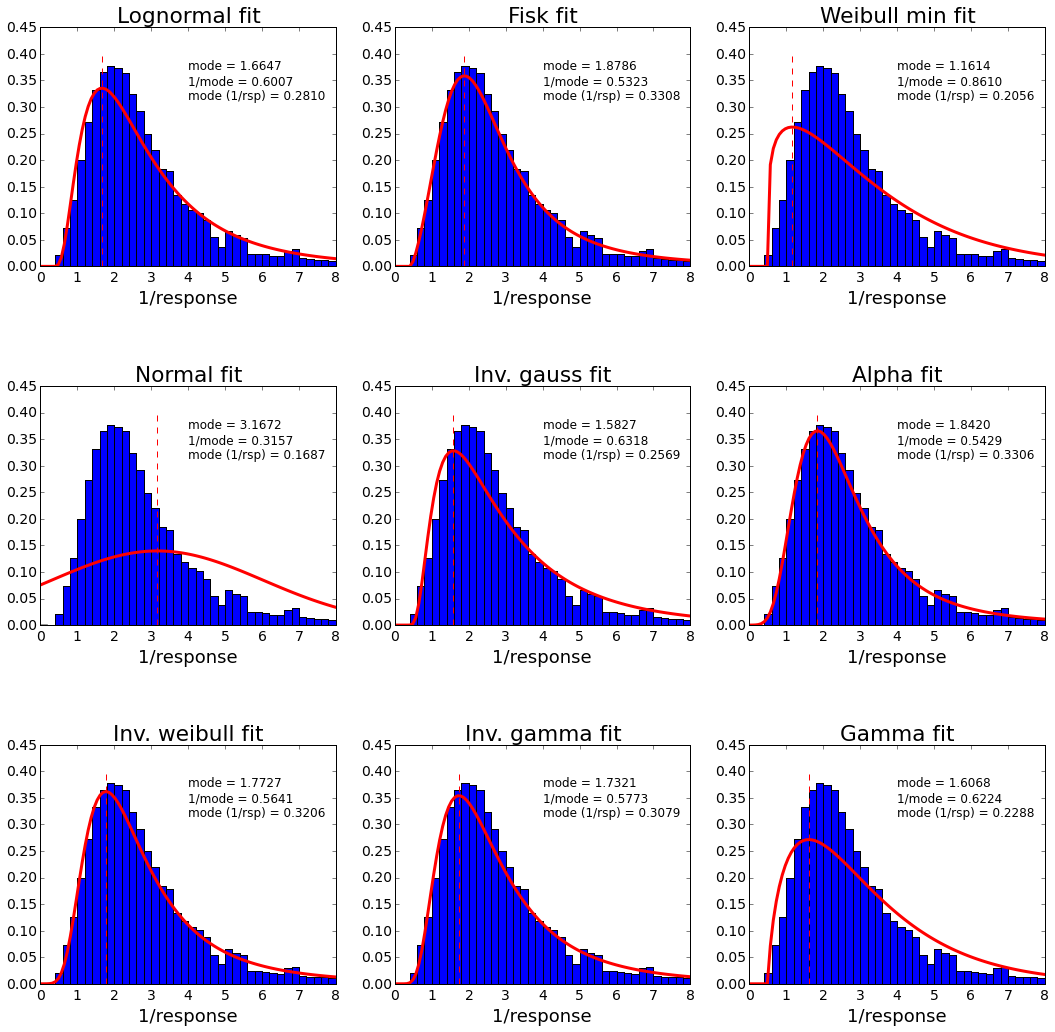

In [217]:
plot_multiple_fits(rspInv, fit_fns, '1/response', [0, 8])

In [240]:
def apply_fit_to_inverse(fit_fn, fn_name):
    """Fit to response, apply function (wiht jacobian) to inverse response."""
    plt.gcf().set_size_inches(14, 6)
    plt.subplot(1, 2, 1)
    ax = plt.gca()
    
    mean = rsp.mean()
    std = rsp.std() * 20
    mask = (rsp < (mean+std)) & (rsp>(mean-std))
    _ = ax.hist(rsp[mask], bins=40, range=[0, 1.5], normed=True)
    shape, loc, scale = fit_fn.fit(rsp[mask])
    print shape, loc, scale
    # plot fitted fn
    x_val = np.arange(0, 1.5, 0.01)
    ax.plot(x_val, fit_fn.pdf(x_val, shape, loc=loc, scale=scale), 'r', linewidth=3)
    ax.set_title('%s fit' % fn_name)
    ax.set_xlabel('response')

    # get mode
    max_result = minimize(lambda x: -1 * fit_fn.pdf(x, shape, loc=loc, scale=scale), x0=0.75)
    mode = max_result.x[0]
    ax.text(0.5, 0.7, 'mode = %.4f\n1/mode = %.4f' % (mode, 1./mode), transform=ax.transAxes)
    
    # plot 1/response
    plt.subplot(1, 2, 2)
    ax = plt.gca()
    _ = ax.hist(rspInv, bins=40, range=[0,8], normed=True)
    x_val = np.arange(0, 8, 0.01)
    ax.plot(x_val, np.power((1./x_val), 2) * fit_fn.pdf(1./x_val, shape, loc=loc, scale=scale), 'r', linewidth=3)
    ax.set_title('Using fit params')
    ax.set_xlabel('1 / response')
    mode = 1.0
    ax.text(0.5, 0.7, 'mode = %.4f\n1/mode = %.4f' % (mode, 1./mode), transform=ax.transAxes)

0.424840316369 -0.124175829665 0.53119838748


/Users/robina/.virtualenvs/ipywidgets/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in divide
/Users/robina/.virtualenvs/ipywidgets/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning: invalid value encountered in multiply


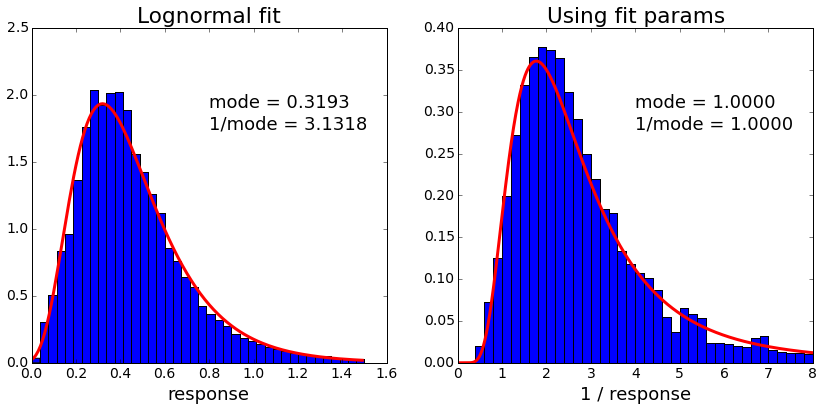

In [241]:
apply_fit_to_inverse(lognorm, 'Lognormal')

3.86248146332 -0.08640309716 0.491336578023


/Users/robina/.virtualenvs/ipywidgets/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide
/Users/robina/.virtualenvs/ipywidgets/lib/python2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in multiply


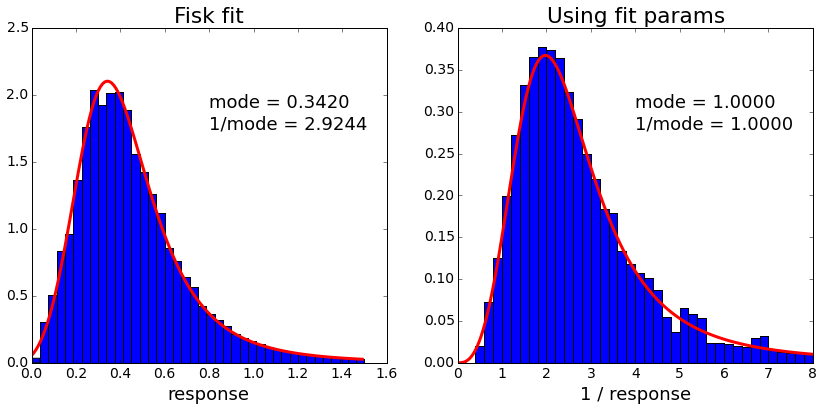

In [195]:
apply_fit_to_inverse(scipy.stats.fisk, 'Fisk')

## Higher ptRef bin (102 - 106 GeV)

Lognormal : 0.154298584152 -0.395180479058 0.943463158564 0.526085983975 1.6619386609
Fisk : 13.0522913071 -0.488558211959 1.03842389756 0.537722528729 1.71387609924
Weibull min : 3.3000411918 0.0287552906783 0.584630310995 0.552804037846 1.51910669019
Normal : 0.559692081878 0.151928993165 0.559692063864 1.58062573904
Inv. gauss : 0.0207993430759 -0.467567076896 49.389017061 0.528142390564 1.65462748416
Alpha : 12.45631967 -1.24640340058 22.3480840921 0.525164338636 1.67046724063
Inv. weibull : 2051026.05626 -281806.747357 281807.236713 0.489356262819 1.73025801486
Inv. gamma : 74.4436063928 -0.700013596616 92.5076433251 0.526169026935 1.66435840176
Gamma : 25.2022502479 -0.184280653455 0.029520089939 0.53017193708 1.64708723704


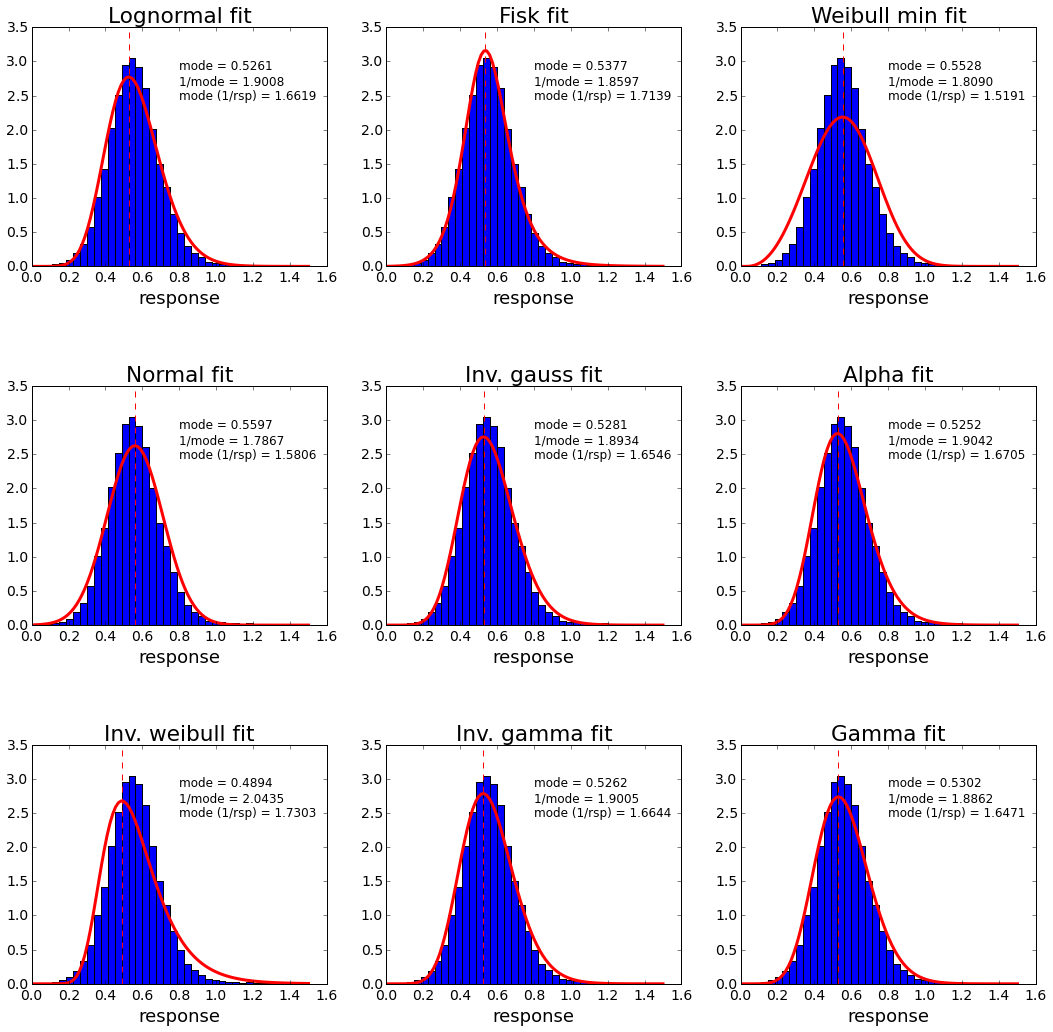

In [218]:
plot_multiple_fits(rspHigh, fit_fns, 'response', [0, 1.5])

Lognormal : 0.320228130616 0.241076118788 1.60193106265 1.68687749962 0.507086571756
Fisk : 5.6614168043 0.291811514753 1.53411814527 1.73217433161 0.527995133912
Weibull min : 2.10155648612 0.305031913279 1.81653491345 1.64087335955 0.415945188052
Normal : 1.93595243815 0.740141787217 1.93594759939 0.417768833697
Inv. gauss : 0.102578190635 0.172725480064 17.1891045228 1.68539994253 0.500982809064
Alpha : 5.47373179232 -0.802305033665 14.3854042251 1.6704672442 0.525164318537
Inv. weibull : 18.0243448183 -5.9493862025 7.61821632113 1.64604219784 0.528781472322
Inv. gamma : 14.4785535068 -0.0459852824027 26.5820698568 1.67136331578 0.517283524303
Gamma : 0.297829835454 0.305204906486 22.8626516015 2.0 0.0338936673274


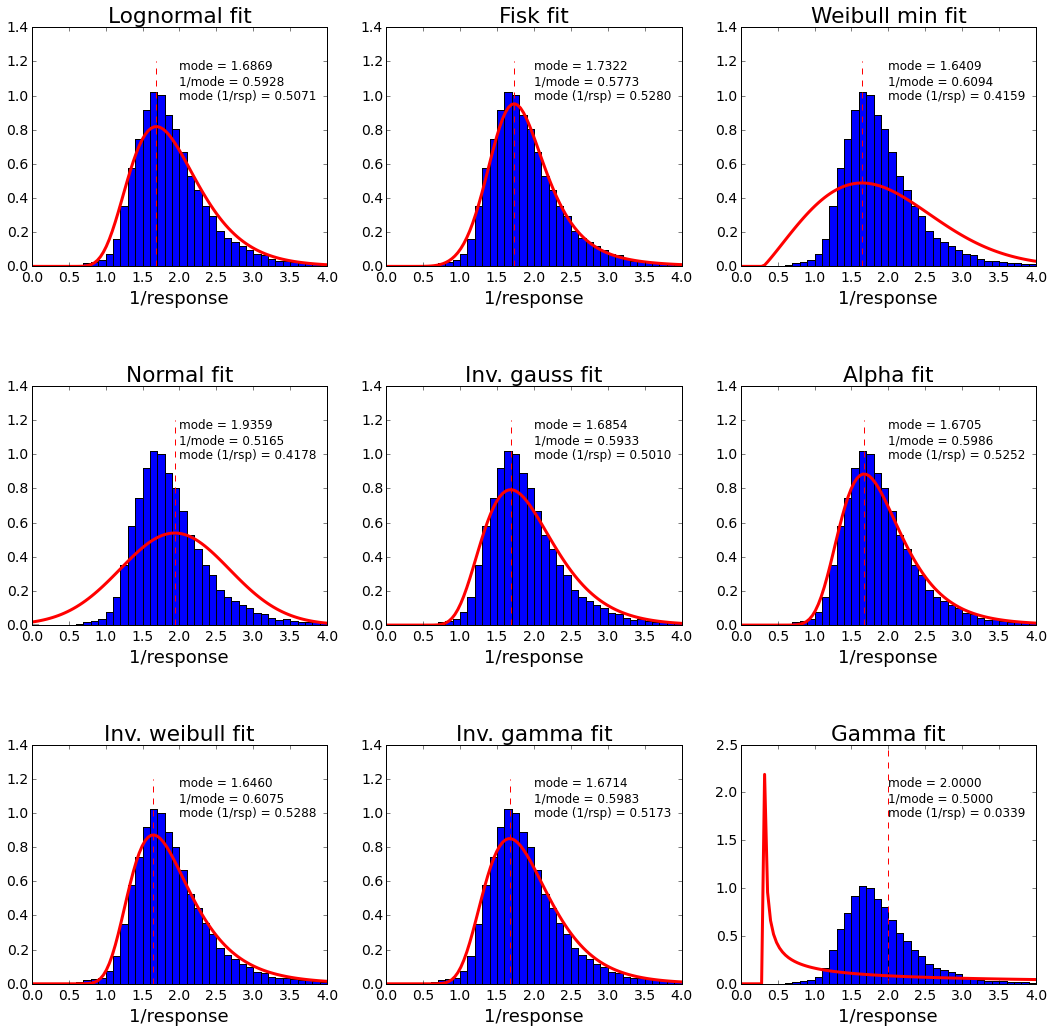

In [219]:
plot_multiple_fits(rspHighInv, fit_fns, '1/response', [0, 4])

# Trying my own fitting

In [35]:
# For the function
x = np.arange(0.01,10,0.01)


def my_lognorm(x, N, m, theta, sigma):
    x = x[x>theta]
    exp = np.power(np.log((x-theta)/m), 2) / (2 * np.power(sigma, 2))
    result = (N * (x - theta) / ( sigma * np.sqrt(2 * np.pi))) * np.exp(-1. * exp)
    return x, result

def my_gamma(x):
    pass

In [36]:
my_lognorm(x=np.arange(0, 1, 0.2), N=1, m=1, theta=0, sigma=0.5)

(array([ 0.2,  0.4,  0.6,  0.8]),
 array([ 0.00089758,  0.05953092,  0.28407908,  0.57780375]))

In [15]:
def plot_hist_fn(hist_data, bins, xlim, x, fn, N, m, theta, sigma):
    plt.hist(hist_data, bins=bins, range=xlim)
    new_x, res = fn(x, N, m, theta, sigma)
    plt.plot(new_x, res, 'r-', linewidth=3)
    plt.xlim(xlim)

<function __main__.plot_hist_fn>

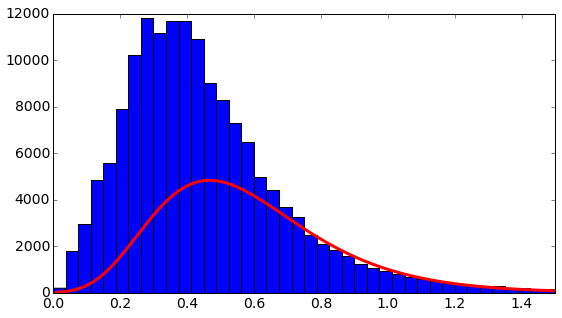

In [110]:
interact(plot_hist_fn, hist_data=fixed(rsp), bins=fixed(40), xlim=fixed([0, 1.5]), 
         x=fixed(x), 
         fn=fixed(my_lognorm), 
         N=widgets.FloatSlider(min=1, max=10000, step=50, value=5851, continuous_update=False), 
         m=widgets.FloatSlider(min=0, max=5, step=0.01, value=0.63, continuous_update=False), 
         theta=widgets.FloatSlider(min=-10, max=10, step=0.01, value=-0.23, continuous_update=False),
         sigma=widgets.FloatSlider(min=0, max=10, step=0.01, value=0.32, continuous_update=False))

<function __main__.plot_hist_fn>

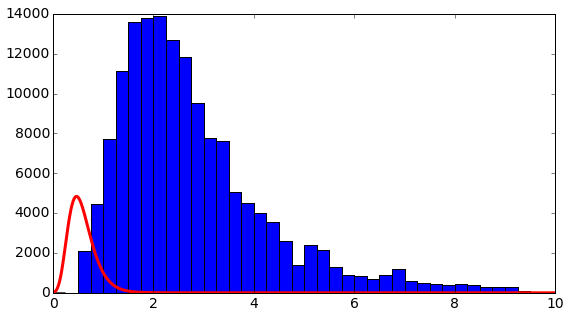

In [111]:
interact(plot_hist_fn, hist_data=fixed(rspInv), bins=fixed(40), xlim=fixed([0, 10]), 
         x=fixed(x), 
         fn=fixed(my_lognorm), 
         N=widgets.FloatSlider(min=1, max=50000, step=50, value=5851, continuous_update=False), 
         m=widgets.FloatSlider(min=0, max=5, step=0.01, value=0.63, continuous_update=False), 
         theta=widgets.FloatSlider(min=-10, max=10, step=0.01, value=-0.23, continuous_update=False),
         sigma=widgets.FloatSlider(min=0, max=10, step=0.01, value=0.32, continuous_update=False))